# A beginner-friendly implementation of the VQE with qiskit 1.0 (Part 1)

## Introduction

In this notebook I consider a very rudimentary application of the Variational Quantum Eigensolver (VQE) to find the ground-state (gs) energy of the Hamiltonian $H = Z$. Of course, this answer is rather elementary to those familiarized with quantum computing: the eigenvalues of $Z$ are $\pm 1$, so that the lowest (gs) value is $-1$. Nevertheless, this presentation is not intended to bring new insight about recent developments of the VQE. Instead, it aims to present a begginer-friendly guide to those starting their journey towards learning this important quantum algotithm.

I assume the reader is familiarized with the following topics:

1. The variational method in quantum mechanics
2. Simulation of quantum circuits and quantum gates with qiskit 1.0 (lattest release)
3. Ansätze (pl. of Ansatz)
4. Basics of Python (libraries like numpy, matplotlib, etc.) and object-oriented programming (classes, functions, etc.)

For a brief introduction to (1), (2) and (3), for example, I recommend you the following resources:

1. [Variational method in quantum mechanics, by Bento Montenegro (the author)](https://drive.google.com/file/d/1F-rsA5u3uWMlLfXKrXMNVpV4qkqWOzUF/view?usp=sharing)
2. [Qiskit pocket guide, by James Weaver and Francis Harkins](https://www.amazon.com.br/Qiskit-Pocket-Guide-Quantum-Development/dp/1098112474)
3. [Musty thoughts tutorials](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)

## Building the Ansatz as a quantum circuit

Suppose that we are given a Hamiltonian $H$ whose eigenstates are unknown, and that our task is to determine its gs-energy. Shortly stated, the variational method consists in trying to find a set of parameters $\xi = (\theta_1, ..., \theta_N)$, such that the _Ansatz_ (= trial state) $|\psi(\xi)\rangle$ produces the lowest value possible when plugged into the expectation value of $H$. Mathematically, we want to find an _optimum_ set of parameters $\xi$ such that the quantity
\begin{equation}
    E_0(\xi) = \langle \psi(\xi) | H | \psi(\xi) \rangle.
\end{equation}
is as low as possible. The so-called _variation theorem_, which is not difficult to prove, ensured that the RHS of this equation is always greater than or equal to the actual gs-energy of a given physical system.

The construction of a general Ansatz can be achieved in qiskit by defining a _parameterized quantum circuit_, i.e. a quantum circuit to which some rotational gates are specified but no specific numerical values are assigned _a priori_ to their rotational angles. In the following code snippet we create a 1-qubit quantum circuit and apply to it two parameterized rotational gates, $R_x(\theta)$ and $R_z(\phi)$.

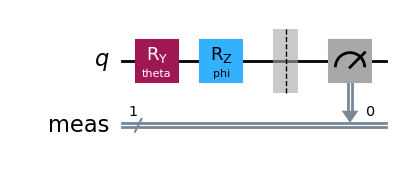

In [1]:
### Parameterized Ansatz

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

## Ansatz for H1 = Z
qc = QuantumCircuit(1) # 1-qubit quantum circuit
theta = Parameter('theta') # Azhimutal angle
phi = Parameter('phi') # Polar angle
qc.ry(theta, 0) # Parameterized y-rotation
qc.rz(phi, 0) # Parameterized z-rotation
qc.measure_all()

qc.draw('mpl')

Of course, the parameters $\theta$ and $\phi$ correspond to the usual (azhimutal and polar) angles of the qubit's Bloch sphere. Specific numerical values will be assigned to them when we start to rock.

<div style = "text-align: center;">
    <img src = "Bloch.png" style = "width:250px; height:260px"/>
</div>

In summary, the VQE consits in the following general steps:

1. An Ansatz is implemented as a parameterized quantum circuit
2. Specific values are assigned to these parameters
3. A quantum computer runs the circuit and returns the expectation value of $H$ to a classical computer
4. The classical computer evaluates somehow if the expectation value is good enough, given the values assigned to the parameters
    1. If the answer is "yes", the process stops and we have an estimate for the gs-energy of the system
    2. If the answer is "no", the classical computer chooses (as wisely as possible) new values to be assigned to the parameters and the whole process is repeated
  
Because one part of this process happens in a quantum computer and the another part in a classical computer, we say that the VQE is a _hybrid_ algorithm. Particular attention has been raised to such processes today, as we are still in the era of NISQ (Near-term Intermediate Scale Quantum) machines. This means that such algorithms can already be explored with good results, serving for several purposes both in a academy and industry.

## Implementing the VQE

### Hamiltonian of the system

As said in the introduction, we consider $H = Z$ for pedagogical purposes. We do not need to specify it using any qiskit function, as will become clear in the function below. However, we could specify it using the `Pauli` class from `qiskit.quantum_info` (i.e. `H = Pauli('Z')` after `from qiskit.quantum_info import Pauli`), then simulate the state vector of our ansatz and finally explicitly calculate its expectation value. Our function, however, relieves us from the necessity of working with vectors, which are multi-component objects that may make calculations heavier.

### Expectation values

Now it is convenient to create a function that simulates a quantum circuit and returns the expectation value of $Z$. Of course, you are likely to ask "what if I want to calculate the expectation value of X, for example?". There is no problem, since if we rotate our coordinate system so that the X direction becomes the Z direction we can still apply the same function. However, in order to make things simpler here, I will cover this in a further notebook. I hope the comments will help you understand what is going on.

In [3]:
### Function to return expectation values from a given Ansatz

from qiskit import transpile
from qiskit_aer import Aer

## Backend to return measurement counts
backend = Aer.get_backend('qasm_simulator')

## Function that returns 1 (-1) if the input is 0 (1)
def Z_eigenvalue(measurement_outcome):
    if measurement_outcome == '0':
        return 1
    else: return -1

## Function that simulates a qc and returns the expectation value of the Pauli operator Z
def ansatz_expectation(ansatz_qc, simulation_shots):
    
    ## Simulating the circuit
    transpiled_ansatz = transpile(ansatz_qc, backend)
    result = backend.run(transpiled_ansatz, shots = simulation_shots).result()
    result_counts = result.get_counts()

    ## Calculating the expectation value of Z
    expectation = 0.0
    for outcome, counts in result_counts.items():
        expectation += Z_eigenvalue(outcome)*counts

    return expectation/simulation_shots

I found simpler to use the `Aer` simulator in this case, but you can use the `BasicAer` or any other simulator that happens to return the number of measurement outcomes of a given circuit. Note that, because a quantum computer is a machine that rotates qubits and necessarily measure them at the end, we must pass the additional argument `simulation_shots` in order to make an _ensamble_ (= collection) of measurements to determine mean values such as $\langle H \rangle$. Recall that we have no direct access to superposition states: quantum mechanics tells that only "single" states can be the outcome of any measurement. I know this sounds rather philosophical, but in fact it is. According to the so-called Copenhagen interpretation (due to Bohr, Heisenberg, Dirac, Pauli et al.), single states are reality, whereas superpositions seems to be the simplest _language_ to describe reality (see the classical double-slit experiment).

### Finding optimum parameters with the gradient-descent method

Now we are ready to start our optimization process according to the well-known _gradient descent_ method.

The basic idea to start at some random point, say $(\theta_0 = 0, \phi_0 = 0)$, and then update our parameters at each new iteraction like this:
\begin{equation}
    \begin{split}
        \theta &\to \theta_0 - \delta \theta \frac{\partial E_0}{\partial \theta} \Bigg|_{(\theta_0, \phi_0)}\\
        \phi &\to \phi - \delta \phi \frac{\partial E_0}{\partial \phi} \Bigg|_{(\theta_0, \phi_0)}
    \end{split}
\end{equation}
where $\partial E_0/\partial \theta = [E_0(\theta + \delta \theta, \phi) - E_0(\theta, \phi)]/\delta \theta$ and $\partial E_0/\partial \phi = [E_0(\theta, \phi + \delta \phi) - E_0(\theta, \phi)]/\delta \phi$ are the components of the _gradient_ of $E_0$, provided that $\delta \theta$ and $\delta \phi$ are small. If you prefer a single equation, take $\xi \equiv (\theta, \phi)$ and $\delta \xi \equiv (\delta \theta, \delta \phi)$, and there it is:
\begin{equation}
    \xi \to \xi_0 - \delta \xi \cdot \nabla E_0 |_{\xi = \xi_0}.
\end{equation}

You might recall from the old days of calculus that the gradient of a function $f(x,y)$ is a vector field on the plane $(x,y)$ which always points in the direction of maximum increase of $f$. This means that the _negative_ gradient of a function always points in the direction of its maximum _decrease_. So the update makes sense (think a little bit about it).

Hopefully the comments will help you again. Read carefully.

In [48]:
### Finding the gs-state of H = Z

from numpy import append, pi

## Initial parameters
theta_0 = 0.0 # Initial trial for theta
phi_0 = 0.0 # Initial trial for phi
shots = 1e4 # Number of shots for our simulations

## Arrays to store optimum parameter values (An instructive plot will be made at the end)
theta_array = [theta_0]
phi_array = [phi_0]

## Initial E_0

E_0 = ansatz_expectation(qc.assign_parameters({theta: theta_0, phi: phi_0}), shots)

## Loop parameters
dtheta = dphi = 0.2 ## Increments
num_iteractions = 50 # Number of optimization trials

## Optimization loop

for iteraction in range(num_iteractions):

    ## Varying parameters
    grad_E_theta = ansatz_expectation(qc.assign_parameters({theta: theta_0 + dtheta, phi: phi_0}), shots) - E_0
    grad_E_phi = ansatz_expectation(qc.assign_parameters({theta: theta_0, phi: phi_0 + dphi}), shots) - E_0

    ## Updating parameters
    theta_0 -= grad_E_theta
    phi_0 -= grad_E_phi

    ## New estimate for E_0
    E_0 = ansatz_expectation(qc.assign_parameters({theta: theta_0, phi: phi_0}), shots)
            
    ## Storing theta_0's and phi_0's
    theta_array.append(theta_0)
    phi_array.append(phi_0)

    print(iteraction + 1, '%.2f'%theta_0, '%.2f'%phi_0, '| E_0 = %.4f'%E_0) # Uncoment this line if you want to watch the progress


1 0.01 0.00 | E_0 = 0.9998
2 0.04 -0.00 | E_0 = 0.9992
3 0.06 0.00 | E_0 = 0.9978
4 0.09 0.00 | E_0 = 0.9924
5 0.13 -0.00 | E_0 = 0.9920
6 0.17 -0.00 | E_0 = 0.9862
7 0.22 -0.00 | E_0 = 0.9800
8 0.29 0.00 | E_0 = 0.9560
9 0.38 0.00 | E_0 = 0.9238
10 0.47 0.00 | E_0 = 0.8848
11 0.56 0.00 | E_0 = 0.8492
12 0.69 -0.00 | E_0 = 0.7716
13 0.83 0.00 | E_0 = 0.6672
14 0.97 -0.00 | E_0 = 0.5648
15 1.15 -0.01 | E_0 = 0.4282
16 1.36 0.02 | E_0 = 0.2218
17 1.58 0.03 | E_0 = -0.0304
18 1.75 0.01 | E_0 = -0.1760
19 1.93 0.02 | E_0 = -0.3424
20 2.11 0.03 | E_0 = -0.5096
21 2.27 0.03 | E_0 = -0.6302
22 2.42 0.03 | E_0 = -0.7414
23 2.53 0.03 | E_0 = -0.8280
24 2.63 0.02 | E_0 = -0.8674
25 2.72 0.02 | E_0 = -0.9152
26 2.78 0.02 | E_0 = -0.9290
27 2.83 0.02 | E_0 = -0.9480
28 2.88 0.03 | E_0 = -0.9644
29 2.92 0.03 | E_0 = -0.9748
30 2.94 0.03 | E_0 = -0.9780
31 2.96 0.03 | E_0 = -0.9844
32 2.98 0.03 | E_0 = -0.9884
33 2.99 0.03 | E_0 = -0.9894
34 3.00 0.03 | E_0 = -0.9878
35 3.01 0.03 | E_0 = -0.9890
36 

You may check that the result estimates the correct answer $(\theta_0 \approx \pi, \phi_0 \approx 0)$ with nice precision. You can also play with the loop parameters in order to achieve the best combination, i.e., the one that produces the correct results with less iteractions. In fact, playing with the paramateres and exploring phisical simmetries of a specific problem might lower the execution time of the algorithm considerably (and this is an active area of research today!).

## Analysis of the process

The following plot might be instructive to visualize our "search path" throughout the $\theta \phi$-plane. You may just run the cell without paying much attention to the code itself, as it ilvolves only standard `matplotlib` functions (nothing especially related to quantum computing).

([<matplotlib.axis.YTick at 0x155a70170>],
 [Text(0, 0.041000000000000064, '0.041')])

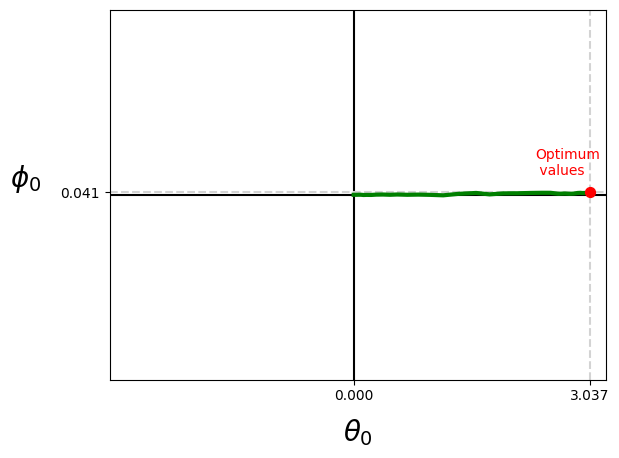

In [49]:
from numpy import zeros, linspace
from matplotlib.pyplot import plot, scatter, xlim, ylim, xlabel, ylabel, xticks, yticks, text

## Plotting x and y axis
plot(linspace(-pi, pi + 0.1, num_iteractions + 1), zeros(num_iteractions + 1), color = 'black') # Horizontal axis line
plot(zeros(num_iteractions + 1), linspace(-pi, pi, num_iteractions + 1),color = 'black') # Vertical axis line

## Plotting two dashed grey lines for reference
plot(zeros(num_iteractions + 1) + theta_array[num_iteractions], linspace(-pi, pi, num_iteractions + 1), color = 'lightgrey', linestyle = 'dashed')
plot(linspace(-pi, pi + 0.1, num_iteractions + 1), zeros(num_iteractions + 1) + phi_array[num_iteractions], color = 'lightgrey', linestyle = 'dashed')

## Plotting our curve of optimum parameters
plot(theta_array, phi_array, color = 'green', zorder = 2, linewidth = 3)

## Plot a red dot on optimum values
scatter(theta_array[num_iteractions], phi_array[num_iteractions], color = 'red', marker = 'o', s = 50, zorder = 3)
text(theta_array[num_iteractions] - 0.7, phi_array[num_iteractions] + 0.3, 'Optimum\n values', color = 'red', fontsize = 10)

## Personalizing the plot for clearer visualization
xlim(-pi, pi + 0.1)
ylim(-pi, pi)
xlabel(r'$\theta_0$', fontsize = 20, labelpad = 10)
ylabel(r'$\phi_0$', fontsize = 20, rotation = 0, labelpad = 25)
xticks([0, theta_array[num_iteractions]])
yticks([phi_array[num_iteractions]])


The optimum values give $| \psi \rangle_{\text{optimum}} = | 1 \rangle$ (i.e. $\theta \approx \pi$ and $\phi \approx 0$), as expected. However, it should be noted that in general trial states that produce a gs-energy fairly close to the actual value for a given system might not be this close to the actual gs-eigenvector. This is a general fact from the variational theory in quantum mechanics.

## Closing remarks

In this notebook I considered a very basic implementation of the VQE for the case of the Hamiltonian $H = Z$. Hopefully it was insctructive for those beginning their journey in quantum computing. However, it should be mentioned that the optimization process we used was also very simple, and several more advanced techniques do exist in current literature (see, for ex. [this great review](https://arxiv.org/abs/2111.05176)). Which one is the best depends on the specific Hamiltonian you are considering (for example, if you need to use a large set of parameters, you may try to exploit physical symmetries in order to hopefully reduce this set). More advanced examples will be covered by me in future notebooks. From now, I hope you enjoyed this one.